In [11]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from rationality.util import ordinal

In [12]:
fm._rebuild()
plt.style.reload_library()
plt.style.use(['science', 'notebook'])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%config InlineBackend.figure_format = 'svg'

In [13]:
percentile = 100

In [14]:
npzfile = np.load('data.npz')
locals().update(npzfile)

In [15]:
def select_percentile(states: np.ndarray, inputs: np.ndarray, costs: np.ndarray, percentile: float) -> np.ndarray:
    cumm_costs = costs.sum(axis=0)
    percentiles = np.percentile(cumm_costs, percentile, axis=0)
        
    if np.isscalar(percentiles) == 1:
        percentiles = np.array([percentiles])
    
    selected_states = []
    selected_inputs = []
    selected_costs = []
    
    
    for i, percentile in enumerate(percentiles):
        selected = cumm_costs[:, i] < percentile
        
        selected_states.append(states[:, :, selected, i])
        selected_inputs.append(inputs[:, :, selected, i])
        selected_costs.append(costs[:, selected, i])
        
    return np.stack(selected_states, axis=-1), np.stack(selected_inputs, axis=-1), np.stack(selected_costs, axis=-1)
        
        
    

In [16]:
num_inv_temps = len(inv_temps)

svmpc_states, svmpc_inputs, svmpc_costs = select_percentile(svmpc_part_states, svmpc_part_inputs, svmpc_part_costs, percentile)
mpc_states, mpc_inputs, mpc_costs = select_percentile(np.stack([mpc_part_states], axis=-1), np.stack([mpc_part_inputs], axis=-1), np.stack([mpc_part_costs], axis=-1), percentile)

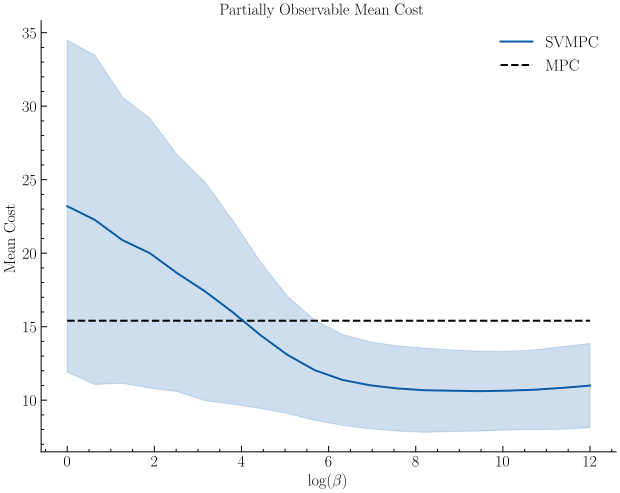

In [17]:
plt.figure()

svmpc_means = svmpc_costs.sum(axis=0).mean(axis=0)[1:]
svmpc_stddevs = svmpc_costs.sum(axis=0).std(axis=0)[1:]

mpc_mean = mpc_costs.sum(axis=0).mean()
mpc_stddev = mpc_costs.sum(axis=0).std()

color = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot(np.log(inv_temps[1:]), svmpc_means, color=color, label='SVMPC')
plt.fill_between(np.log(inv_temps[1:]), svmpc_means + svmpc_stddevs, svmpc_means - svmpc_stddevs, color=color, alpha=0.2)

plt.hlines(mpc_mean, np.log(inv_temps[1]), np.log(inv_temps[-1]), linestyles='dashed', colors='k', label='MPC')
#plt.hlines([mpc_mean + mpc_stddev, mpc_mean - mpc_stddev], np.log(inv_temps[1]), np.log(inv_temps[-2]), linestyles='dotted', colors='k', label='mpc')
#plt.fill_between(np.log(inv_temps[[1, -2]]), mpc_means + mpc_stddevs, mpc_means - mpc_stddevs, color='black', alpha=0.2)


plt.title('Partially Observable Mean Cost')
plt.xlabel(r'$\log(\beta)$')
plt.ylabel(r'Mean Cost')
plt.legend()

plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
sns.despine()

plt.gca().set_position([0, 0, 1, 1])
plt.gcf().patch.set_alpha(1)
plt.savefig('figures/log-beta-vs-performance.svg')
plt.savefig('figures/log-beta-vs-performance.png')

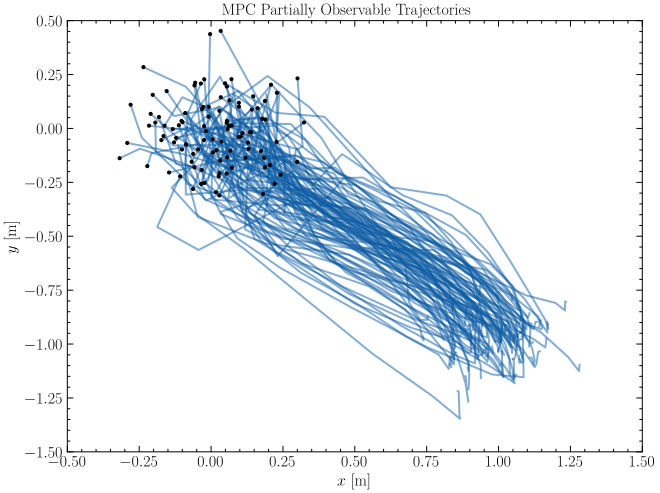

In [18]:
plt.figure()
color = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot(mpc_states[0, :, :, 0], mpc_states[1, :, :, 0], c=color, alpha=0.5)
plt.scatter(mpc_states[0, -1, :, 0], mpc_states[1, -1, :, 0], c='k', zorder=3, s=10)
plt.xlim([-0.5, 1.5])
plt.ylim([-1.5, 0.5])
plt.title(f'MPC Partially Observable Trajectories{f" ({ordinal(percentile)} Percentile)" if percentile < 100 else ""}')
plt.xlabel('$x\ [\mathrm{m}]$')
plt.ylabel('$y\ [\mathrm{m}]$')

plt.gca().set_position([0, 0, 1, 1])
plt.gcf().patch.set_alpha(1)
plt.savefig('figures/mpc-partial-trajs.svg')
plt.savefig('figures/mpc-partial-trajs.png')

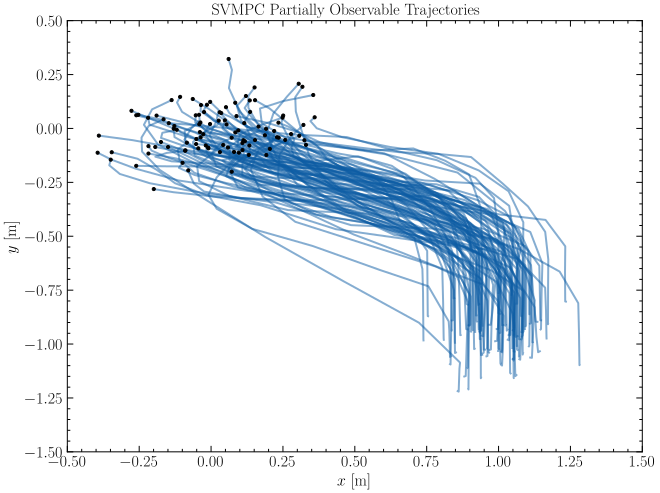

In [19]:
best_idx = svmpc_means.argmin()

plt.figure()
color = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot(svmpc_states[0, :, :, best_idx], svmpc_states[1, :, :, best_idx], c=color, alpha=0.5)
plt.scatter(svmpc_states[0, -1, :, best_idx], svmpc_states[1, -1, :, best_idx], c='k', zorder=3, s=10)
plt.xlim([-0.5, 1.5])
plt.ylim([-1.5, 0.5])

plt.title(f'SVMPC Partially Observable Trajectories{f" ({ordinal(percentile)} Percentile)" if percentile < 100 else ""}')
plt.xlabel('$x\ [\mathrm{m}]$')
plt.ylabel('$y\ [\mathrm{m}]$')

plt.gca().set_position([0, 0, 1, 1])
plt.gcf().patch.set_alpha(1)
plt.savefig('figures/svmpc-partial-trajs.svg')
plt.savefig('figures/svmpc-partial-trajs.png')

In [20]:
best_idx

15